In [5]:
import xgboost as xgb
import numpy as np
import pandas as pd
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from copy import deepcopy

In [6]:
track=pd.read_csv("nfl-big-data-bowl-2022/tracking2018.csv")
plays=pd.read_csv("nfl-big-data-bowl-2022/plays.csv")

plays=plays[plays["specialTeamsResult"]=="Return"]  #Look only at kick/punt returns

#Identify name of receivers so that we can match both datasets
plays["receiver"]=plays["playDescription"].map(lambda x: re.findall(" ([A-Z])\.([A-Z].*?) ", x)[-1] if len(re.findall(" [A-Z]\.([A-Z].*?) ", x))>=1 else 0)
plays=plays[plays["receiver"]!=0]
plays["receiver"]=plays["receiver"].map(lambda x: x[:-1] if x[-1]=="," else x)

#Match games and plays in both datasets
plays["gamePlayId"]=list(zip(plays["gameId"], plays["playId"]))
track["gamePlayId"]=list(zip(track["gameId"], track["playId"]))
track["gamePlayFrameId"]=list(zip(track["gamePlayId"], track["frameId"]))
track=track[track["gamePlayId"].isin(plays["gamePlayId"])]
plays=plays[plays["gamePlayId"].isin(track["gamePlayId"])]

#Create the datasets that match
track["name"]=track["displayName"].map(lambda x: (x.split(" ")[0][0],x.split(" ")[-1]))
plays["nameGamePlayId"]=list(zip(plays["receiver"], plays["gamePlayId"]))
track["nameGamePlayId"]=list(zip(track["name"], track["gamePlayId"]))
track_ret=track[track["nameGamePlayId"].isin(plays["nameGamePlayId"])]
track_ret["nameGamePlayFrameId"]=list(zip(track_ret["nameGamePlayId"],track_ret["frameId"]))
track_ret=track_ret[~track_ret.duplicated("nameGamePlayFrameId", False)]  #Remove seven instances of two players with same initial and last name
plays_ret=plays[plays["nameGamePlayId"].isin(track_ret["nameGamePlayId"])]

track=track[track["gamePlayId"].isin(track_ret["gamePlayId"])]  #Only games and plays where we identified the returner

#Sort values so games are in same place
plays_ret=plays_ret.sort_values("gamePlayId")
plays_ret=plays_ret.reset_index()
track_ret=track_ret.sort_values("gamePlayId")
track_ret=track_ret.reset_index()

C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
data=pd.DataFrame()
data[["receiver", "receiverx", "receivery", "receivers", "receivera", "receiverdir", "gamePlayId", "frameId", "gamePlayFrameId"]]=track_ret[["name", "x", "y", "s", "a", "dir", "gamePlayId", "frameId", "gamePlayFrameId"]]

In [8]:
pivot_track=pd.pivot_table(track, index="gamePlayFrameId", aggfunc=lambda x: [y for y in x])

In [9]:
pivot_track.columns

Index(['a', 'dir', 'dis', 'displayName', 'event', 'frameId', 'gameId',
       'gamePlayId', 'jerseyNumber', 'name', 'nameGamePlayId', 'nflId', 'o',
       'playDirection', 'playId', 'position', 's', 'team', 'time', 'x', 'y'],
      dtype='object')

In [10]:
for col in ['event', 'frameId', 'gameId', 'gamePlayId', 'playDirection', 'playId', 'time']:
    pivot_track[col]=pivot_track[col].map(lambda x: x[0])

In [11]:
for col in ["x", "y", "s", "a", "dir", "team"]:
    for i in range(22):
        pivot_track[str(i)+col]=pivot_track[col].map(lambda x: x[i])


In [12]:
pivot_data=pivot_track.drop(["x", "y", "s", "a", "dir", "team", 'dis', 'displayName',"jerseyNumber", "name", "nameGamePlayId", "nflId", "o", "position"], axis=1)

In [13]:
data=data.set_index("gamePlayFrameId")
pivot_data[["receiver", "receiverx", "receivery", "receivers", "receivera", "receiverdir"]]=data[["receiver", "receiverx", "receivery", "receivers", "receivera", "receiverdir"]]

In [14]:
pivot_data["playMaxDist"]=pivot_data.groupby("gamePlayId")["receiverx"].transform("max")
pivot_data["playMinDist"]=pivot_data.groupby("gamePlayId")["receiverx"].transform("min")

In [15]:
pivot_data["direction"]=(pivot_data["playDirection"]=="left").astype("int32")
pivot_data["direction"]=pivot_data["direction"]*2-1

In [16]:
pivot_data.loc[pivot_data["direction"]==1, "dist"]=(pivot_data["playMaxDist"]-pivot_data["receiverx"])*pivot_data["direction"]
pivot_data.loc[pivot_data["direction"]==-1, "dist"]=(pivot_data["playMinDist"]-pivot_data["receiverx"])*pivot_data["direction"]

In [17]:
receive_frames={}
for x in pivot_data[(pivot_data["event"]=="kick_received")|(pivot_data["event"]=="punt_received")].index:
    receive_frames[x[0]]=x[1]

In [18]:
pivot_data["received?"]=pivot_data["gamePlayId"].apply(lambda x: receive_frames[x] if x in receive_frames.keys() else 0)
pivot_data["received?"]=(pivot_data["frameId"]>=pivot_data["received?"])

In [19]:
pivot_data

,event,frameId,gameId,gamePlayId,playDirection,playId,time,0x,1x,2x,...,receiverx,receivery,receivers,receivera,receiverdir,playMaxDist,playMinDist,direction,dist,received?
gamePlayFrameId,,,,,,,,,,,,,,,,,,,,,
"((2018090600, 366), 1)",None,1,2018090600,"(2018090600, 366)",right,366,2018-09-07T01:18:14.000,13.74,18.61,19.01,...,68.11,27.17,1.49,0.53,216.41,73.27,65.55,-1,2.56,False
"((2018090600, 366), 2)",None,2,2018090600,"(2018090600, 366)",right,366,2018-09-07T01:18:14.100,13.74,18.59,19.01,...,68.02,27.05,1.48,0.47,217.84,73.27,65.55,-1,2.47,False
"((2018090600, 366), 3)",None,3,2018090600,"(2018090600, 366)",right,366,2018-09-07T01:18:14.200,13.75,18.56,19.01,...,67.93,26.94,1.42,0.68,222.30,73.27,65.55,-1,2.38,False
"((2018090600, 366), 4)",None,4,2018090600,"(2018090600, 366)",right,366,2018-09-07T01:18:14.300,13.75,18.53,19.01,...,67.83,26.84,1.42,0.66,224.87,73.27,65.55,-1,2.28,False
"((2018090600, 366), 5)",None,5,2018090600,"(2018090600, 366)",right,366,2018-09-07T01:18:14.400,13.76,18.50,19.01,...,67.72,26.75,1.40,0.72,228.62,73.27,65.55,-1,2.17,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"((2018123015, 3287), 94)",None,94,2018123015,"(2018123015, 3287)",right,3287,2018-12-30T23:49:05.800,83.19,83.87,84.52,...,87.52,21.83,0.82,4.34,348.51,115.55,87.52,-1,-0.00,True
"((2018123015, 3287), 95)",None,95,2018123015,"(2018123015, 3287)",right,3287,2018-12-30T23:49:05.900,83.02,83.89,84.48,...,87.52,21.90,0.69,3.64,16.42,115.55,87.52,-1,-0.00,True
"((2018123015, 3287), 96)",None,96,2018123015,"(2018123015, 3287)",right,3287,2018-12-30T23:49:06.000,82.85,83.92,84.47,...,87.56,21.96,0.70,3.02,44.53,115.55,87.52,-1,0.04,True


In [20]:
with open("pivot_data_dist_reg.pickle", "wb") as f:
    pickle.dump((pivot_data, data), f)

In [21]:
with open("pivot_data_dist_reg.pickle", "rb") as f:
    pivot_data, data=pickle.load(f)

In [22]:
y=pivot_data["dist"]

In [23]:
columns=["receiverx", "receivery", "receivers", "receivera", "receiverdir"]
for stat in ["x", "y", "s", "a", "dir"]:
    for i in range(22):
        columns.append(str(i)+stat)

In [24]:
def perm(n, clust=5, skip=1):
    perm=np.random.permutation(range(skip, n+skip)).tolist()
    permclust=[]
    for i in perm: 
        for j in range(clust):
            permclust+=[clust*i+j]
    return permclust


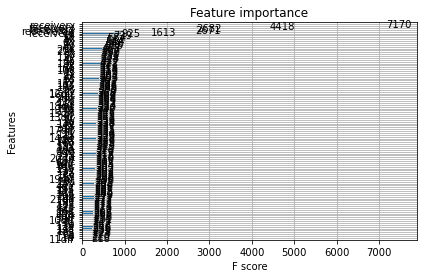

In [38]:
reg_class_scores=pd.DataFrame(columns=["Error"])
scaler=StandardScaler()
X=pivot_data[pivot_data["received?"]==True][columns+["dist"]]
X=X.to_numpy()
for i in range(3): #permutation is not right as it can shuffle different stats not only players
    X=np.concatenate([X, X[:, [0,1,2,3,4]+perm(22)+[115]]], axis=0)
y=X[:,115]
X=scaler.fit_transform(X[:, :115])
y_scaler=StandardScaler()
y_scale=y_scaler.fit_transform(np.reshape(y, (-1,1)))
x_train, x_test, y_train, y_test=train_test_split(X, y_scale, test_size=.2, random_state=1)

x_train=pd.DataFrame(x_train, columns=columns)
x_test=pd.DataFrame(x_test, columns=columns)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2, num_parallel_tree=1,
            max_depth = 10, reg_lambda = 1, n_estimators = 100)

xg_reg.fit(x_train, y_train)

xgb.plot_importance(xg_reg)

pred=xg_reg.predict(x_test)

reg_class_scores=np.sqrt(mean_squared_error(y_test, pred))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

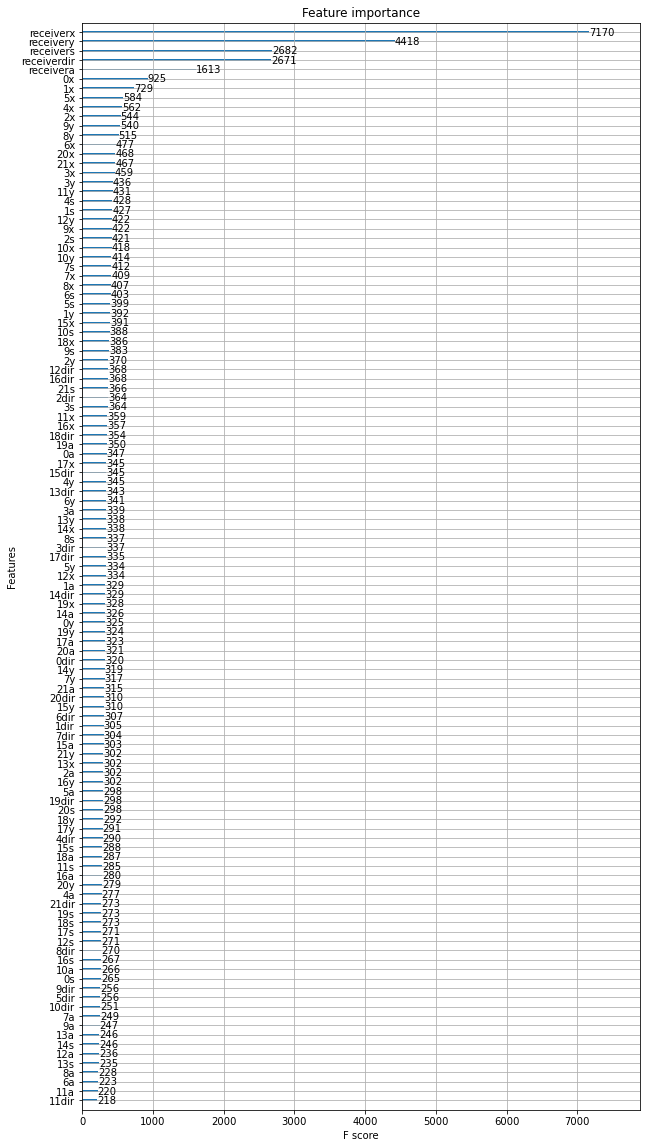

In [39]:
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(xg_reg, ax=ax)

In [40]:
mean_squared_error(y_train, xg_reg.predict(x_train))

0.09317077436344673

In [41]:
mean_squared_error(y_test, pred)

0.13106293401776564

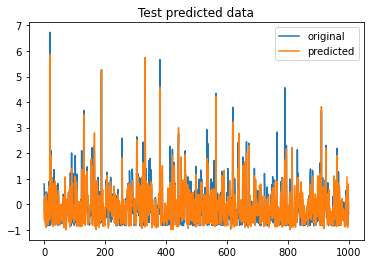

In [42]:
x_ax = range(len(y_test))
plt.plot(x_ax[:1000], y_test[:1000], label="original")
plt.plot(x_ax[:1000], pred[:1000], label="predicted")
plt.title("Test predicted data")
plt.legend()
plt.show()

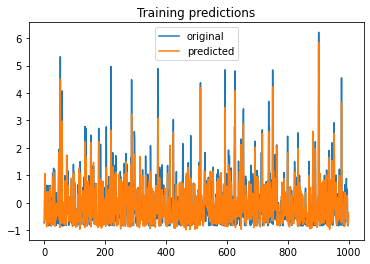

In [43]:
x_ax = range(len(y_train))
plt.plot(x_ax[:1000], y_train[:1000], label="original")
plt.plot(x_ax[:1000], xg_reg.predict(x_train)[:1000], label="predicted")
plt.title("Training predictions")
plt.legend()
plt.show()